In [1]:
## Passo 1: Carregamento e visualização da base de dados

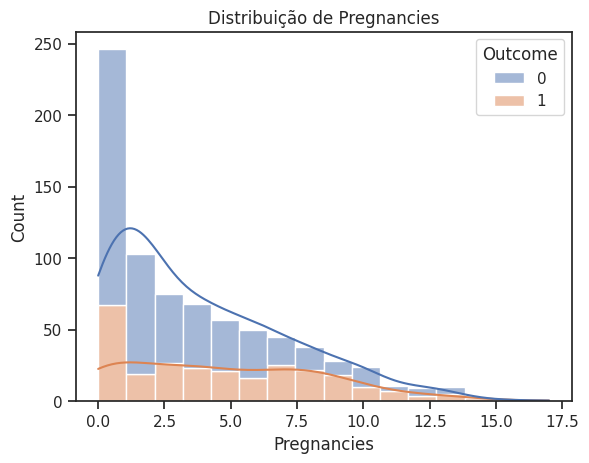

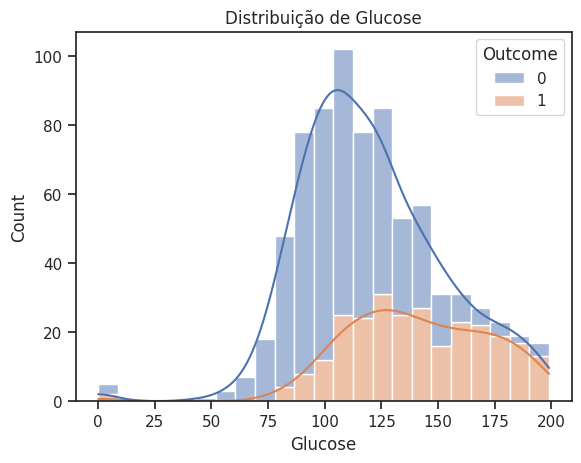

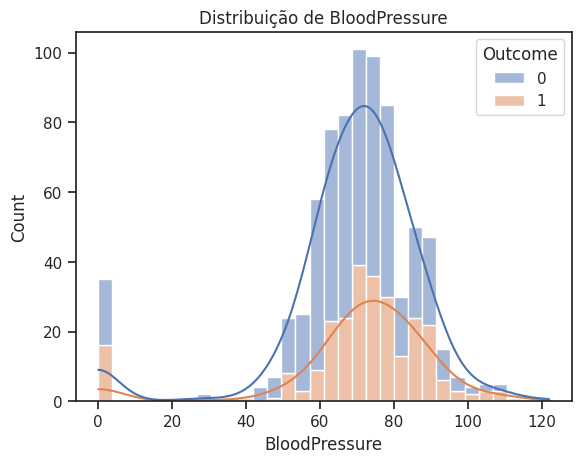

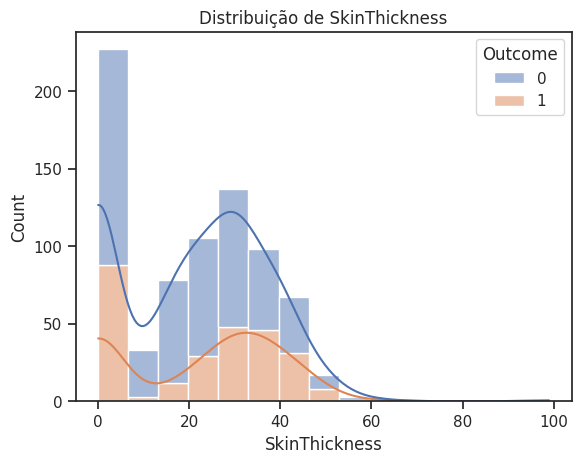

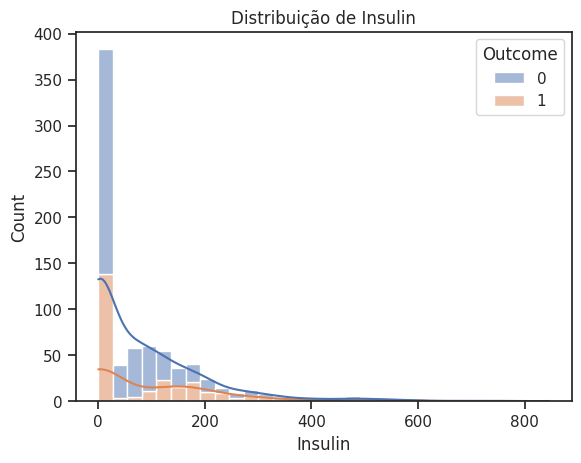

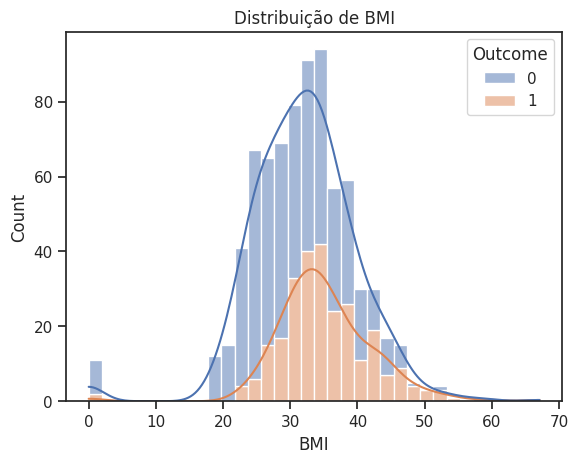

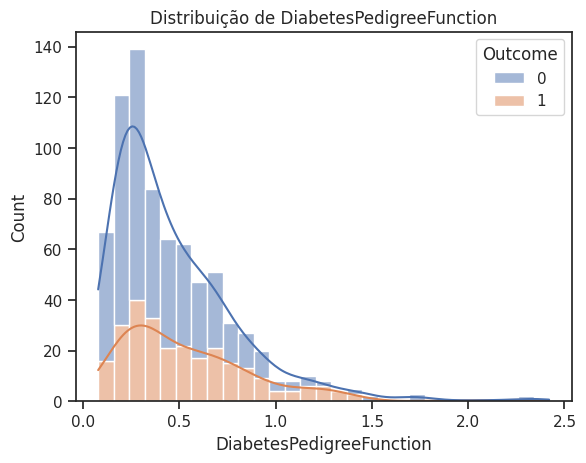

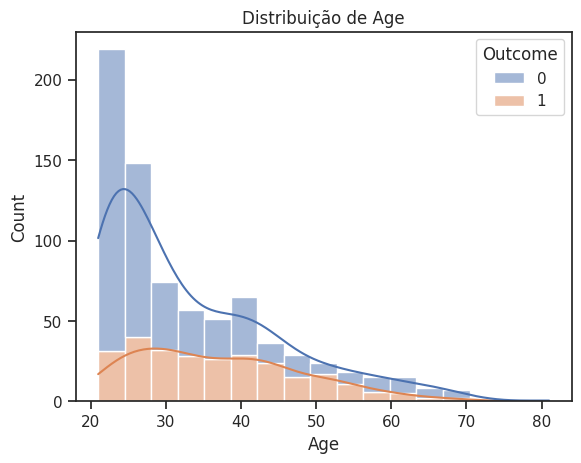

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


df = pd.read_csv("diabetes.csv")

sns.set(style="ticks")

numeric_columns = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

for column in numeric_columns:
    sns.histplot(data=df, x=column, hue="Outcome", multiple="stack", kde=True)
    plt.title(f"Distribuição de {column}")
    plt.show()

In [3]:
### Passo 2: análise de correlação entre os atributos da base

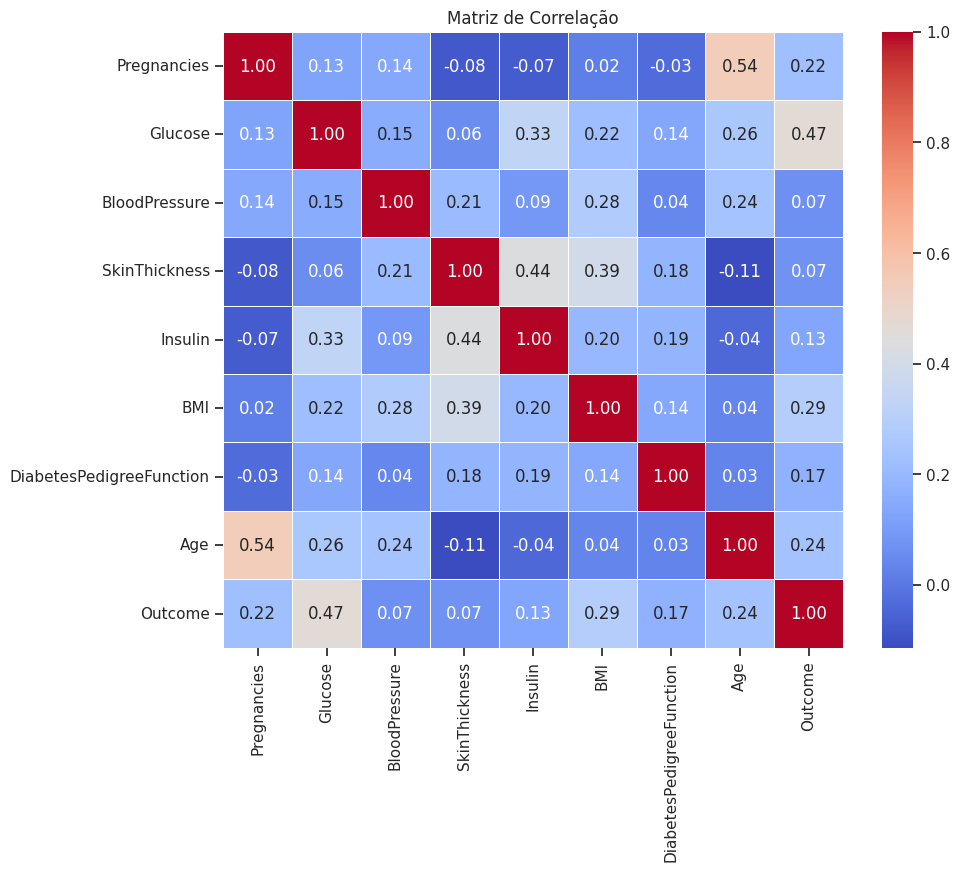

In [4]:
# Calcular a matriz de correlação
correlation_matrix = df.corr()

# Plotar mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

In [5]:
### Passo 3: Remoção de outliers

In [6]:
limit = 3

z_scores = stats.zscore(df['Pregnancies'])
outliers_p = df['Pregnancies'][abs(z_scores) > limit]

z_scores = stats.zscore(df['Glucose'])
outliers_g = df['Glucose'][abs(z_scores) > limit]

z_scores = stats.zscore(df['BloodPressure'])
outliers_b = df['BloodPressure'][abs(z_scores) > limit]

# body mass index (18.5 - 24.9 [Obesity > 30])
z_scores = stats.zscore(df['BMI'])
outliers_bmi = df['BMI'][abs(z_scores) > limit]

# Probability of diabetes based on family history
z_scores = stats.zscore(df['DiabetesPedigreeFunction'])
outliers_dpf = df['DiabetesPedigreeFunction'][abs(z_scores) > limit]

z_scores = stats.zscore(df['Age'])
outliers_a = df['Age'][abs(z_scores) > limit]

In [7]:
unique_outliers = list(set(outliers_g.index) | set(outliers_b.index) | set([9,49,60,81,145,371,426,494,522,684,706]))
df.drop(unique_outliers, inplace=True)

In [8]:
### Passo 4: Pre-processamento normalização dos dados

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X = df.drop("Outcome", axis=1)
y = df["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Tamanho do conjunto de treino:", len(X_train))
print("Tamanho do conjunto de teste:", len(X_test))
print(y_train.value_counts(normalize=True) * 100)
print(y_test.value_counts(normalize=True) * 100)


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

Tamanho do conjunto de treino: 579
Tamanho do conjunto de teste: 145
Outcome
0    65.630397
1    34.369603
Name: proportion, dtype: float64
Outcome
0    65.517241
1    34.482759
Name: proportion, dtype: float64


In [10]:
### Passo 5: treinamento e teste dos modelos

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

#log_reg_model = LogisticRegression(class_weight='balanced')
log_reg_model = LogisticRegression(C=0.0094, penalty='l1', solver='liblinear', max_iter=126)
dt_model = DecisionTreeClassifier()
rf_classifier = RandomForestClassifier(n_estimators=227, random_state=25, bootstrap=False, min_weight_fraction_leaf=0.0100479)
# knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model = KNeighborsClassifier(n_neighbors=6, weights='distance', algorithm='ball_tree', leaf_size=66)

svm = Pipeline([("linear_svc", LinearSVC(C=1))])

log_reg_model.fit(X_train_scaled, y_train)
dt_model.fit(X_train_scaled, y_train)
rf_classifier.fit(X_train_scaled, y_train)
knn_model.fit(X_train_scaled, y_train)
svm.fit(X_train_scaled, y_train)

y_pred_logreg = log_reg_model.predict(X_test_scaled)
y_pred_dt = dt_model.predict(X_test_scaled)
y_pred_rf = rf_classifier.predict(X_test_scaled)
y_pred_knn = knn_model.predict(X_test_scaled)

print("Classification Report Logistic Regression:\n")
print(classification_report(y_test, y_pred_logreg))
y_pred_proba = log_reg_model.predict_proba(X_test_scaled)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC Score: {auc_score:.4f}")
print("Classification Report Decision Tree:\n")
print(classification_report(y_test, y_pred_dt))
y_pred_proba = dt_model.predict_proba(X_test_scaled)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC Score: {auc_score:.4f}")
print("Classification Report Random Forest:\n")
print(classification_report(y_test, y_pred_rf))
y_pred_proba = rf_classifier.predict_proba(X_test_scaled)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC Score: {auc_score:.4f}")
print("Classification Report KNN:\n")
print(classification_report(y_test, y_pred_knn))
y_pred_proba = knn_model.predict_proba(X_test_scaled)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC Score: {auc_score:.4f}")

Classification Report Logistic Regression:

              precision    recall  f1-score   support

           0       0.84      0.66      0.74        95
           1       0.54      0.76      0.63        50

    accuracy                           0.70       145
   macro avg       0.69      0.71      0.69       145
weighted avg       0.74      0.70      0.70       145


AUC Score: 0.7568
Classification Report Decision Tree:

              precision    recall  f1-score   support

           0       0.77      0.74      0.75        95
           1       0.54      0.58      0.56        50

    accuracy                           0.68       145
   macro avg       0.65      0.66      0.66       145
weighted avg       0.69      0.68      0.69       145


AUC Score: 0.6584
Classification Report Random Forest:

              precision    recall  f1-score   support

           0       0.78      0.82      0.80        95
           1       0.62      0.56      0.59        50

    accuracy            

In [12]:
### Passo 6: Validação cruzada

In [13]:
from sklearn.model_selection import cross_val_score, KFold

k_fold = KFold(n_splits=10, shuffle=True)
log_result = cross_val_score(log_reg_model, X_scaled, y, cv  = k_fold, scoring='f1')
dt_result = cross_val_score(dt_model, X_scaled, y, cv = k_fold, scoring='f1')
rf_result = cross_val_score(rf_classifier, X_scaled, y, cv = k_fold, scoring='f1')
knn_result = cross_val_score(knn_model, X_scaled, y, cv = k_fold, scoring='f1')
svm_result = cross_val_score(svm, X_scaled, y, cv = k_fold, scoring='f1')

  # Creates a dictionary to store Linear Models.
dic_models = {
    "LOG": log_result.mean(),
    "DT": dt_result.mean(),
    "RF": rf_result.mean(),
    "KNN": knn_result.mean(),
    "SVM": svm_result.mean(),
}
# Select the best model.
best_model = max(dic_models, key=dic_models.get)

print("Logistic Regression: {0}\nDecision Tree: {1}\nRandom Forest: {2}\nKNN: {3}\nSVM: {4}".format(log_result.mean(), dt_result.mean(), rf_result.mean(), knn_result.mean(), svm_result.mean()))
print("O melhor modelo f1 score é : {0} com o valor: {1}".format(best_model, dic_models[best_model]))

log_result = cross_val_score(log_reg_model, X_scaled, y, cv  = k_fold, scoring='recall')
dt_result = cross_val_score(dt_model, X_scaled, y, cv = k_fold, scoring='recall')
rf_result = cross_val_score(rf_classifier, X_scaled, y, cv = k_fold, scoring='recall')
knn_result = cross_val_score(knn_model, X_scaled, y, cv = k_fold, scoring='recall')
svm_result = cross_val_score(svm, X_scaled, y, cv = k_fold, scoring='recall')

  # Creates a dictionary to store Linear Models.
dic_models = {
    "LOG": log_result.mean(),
    "DT": dt_result.mean(),
    "RF": rf_result.mean(),
    "KNN": knn_result.mean(),
    "SVM": svm_result.mean(),
}
# Select the best model.
best_model = max(dic_models, key=dic_models.get)

print("Logistic Regression: {0}\nDecision Tree: {1}\nRandom Forest: {2}\nKNN: {3}\nSVM: {4}".format(log_result.mean(), dt_result.mean(), rf_result.mean(), knn_result.mean(), svm_result.mean()))
print("O melhor modelo recall score é : {0} com o valor: {1}".format(best_model, dic_models[best_model]))

Logistic Regression: 0.6230384089987788
Decision Tree: 0.5577525401278185
Random Forest: 0.6158146068442141
KNN: 0.5865329542016363
SVM: 0.6156039380886261
O melhor modelo f1 score é : LOG com o valor: 0.6230384089987788
Logistic Regression: 0.7261589891795206
Decision Tree: 0.5343634626243322
Random Forest: 0.5883163714806716
KNN: 0.5692033031245827
SVM: 0.5511329025242069
O melhor modelo recall score é : LOG com o valor: 0.7261589891795206


In [14]:
### Passo 7: Interpretação dos resultados

In [15]:
import shap
import os
from openai import OpenAI

def predict_fn(data):
    return knn_model.predict(data)

data = shap.utils.sample(X_test_scaled, 10)
knn_explainer = shap.KernelExplainer(predict_fn, data)
knn_shap_values = knn_explainer.shap_values(X_test_scaled)

client = OpenAI()

def get_openai_response(prompt_text):
    """
    Sends a prompt to the OpenAI API and returns the response content.
    """
    try:
        chat_completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "Você é um especialista em Machine Learning, que ajuda a traduzir métricas de inferência de um modelo para clientes finais da área da saúde."},
                {"role": "user", "content": prompt_text}
            ],
            max_tokens=15000, # Limits the length of the response
            temperature=0.0, # Controls creativity (0.0 is deterministic, 1.0 is very creative)
        )
        return chat_completion.choices[0].message.content.strip()
    except Exception as e:
        return f"An error occurred: {e}"

user_prompt = """
### Tarefa principal
Explique para o clínico final, como o diagnóstico foi elaborado, explique apenas a relação das colunas com diagnóstico positivo ou negativo de diabetes. 
Você vai receber como exemplo o output de feature importance da inferência de um modelo, portanto preciso que você o interprete e o explique.

### Colunas utilizadas do dataset/feature importance (em ordem)
"Pregnancies" - Número de gestações, "Glucose" - índice de glicose, "BloodPressure" - Pressão sanguínea,
"SkinThickness" - Espessura da pele, "Insulin" - Insulina, "BMI" - IMC (índice de massa corporal), 
"DiabetesPedigreeFunction" - Tendência genética a ter diabetes, "Age" - idade
e o fature importance do modelo foi o seguinte: {data}

### Características do modelo
O modelo está analisando considerando as colunas, um diagnóstico positivo ou negativo de diabetes.
Toda a população do dataset e do subconjunto de feature importance analisado são de pessoas do sexo biológico feminino.
""".format(data=data)

print(user_prompt)

response = get_openai_response(user_prompt)
print(response)

  0%|          | 0/145 [00:00<?, ?it/s]


### Tarefa principal
Explique para o clínico final, como o diagnóstico foi elaborado, explique apenas a relação das colunas com diagnóstico positivo ou negativo de diabetes. 
Você vai receber como exemplo o output de feature importance da inferência de um modelo, portanto preciso que você o interprete e o explique.

### Colunas utilizadas do dataset/feature importance (em ordem)
"Pregnancies" - Número de gestações, "Glucose" - índice de glicose, "BloodPressure" - Pressão sanguínea,
"SkinThickness" - Espessura da pele, "Insulin" - Insulina, "BMI" - IMC (índice de massa corporal), 
"DiabetesPedigreeFunction" - Tendência genética a ter diabetes, "Age" - idade
e o fature importance do modelo foi o seguinte: [[ 0.98927261 -0.47681761  0.13750504 -1.40664001 -0.73711058 -0.40149587
  -0.66021568 -0.16977989]
 [-0.51727353 -0.31426615  0.21712045  0.64906484 -0.73711058  0.49035524
  -0.96810496 -1.02756834]
 [ 0.68796338 -0.47681761  1.25212086 -1.40664001 -0.73711058  0.65118085
   0.71366